<a href="https://colab.research.google.com/github/YonatanLeulseged/ML_AgePredictionModel/blob/main/Final_Project_CSC180.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ethan Covert, Yonatan, Jose Torres, CSC180, Final Project

# Helpful Functions for Tensorflow

In [ ]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Import Dataset

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arashnic/faces-age-detection-dataset
!unzip faces-age-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/4047.jpg          
  inflating: Train/4049.jpg          
  inflating: Train/405.jpg           
  inflating: Train/4051.jpg          
  inflating: Train/4052.jpg          
  inflating: Train/4053.jpg          
  inflating: Train/4055.jpg          
  inflating: Train/4056.jpg          
  inflating: Train/4057.jpg          
  inflating: Train/4058.jpg          
  inflating: Train/4059.jpg          
  inflating: Train/406.jpg           
  inflating: Train/4060.jpg          
  inflating: Train/4061.jpg          
  inflating: Train/4062.jpg          
  inflating: Train/4065.jpg          
  inflating: Train/4066.jpg          
  inflating: Train/4068.jpg          
  inflating: Train/4069.jpg          
  inflating: Train/407.jpg           
  inflating: Train/4070.jpg          
  inflating: Train/4072.jpg          
  inflating: Train/4073.jpg          
  inflating: Train/4076.jpg          
  inflating: Train/4078.jpg          

# Data Prep

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [ ]:
df = df.astype({"ID": str})

In [ ]:
df['ID'] = df['ID'].str.replace('.jpg', '').astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
df = df.sort_values(by=['ID'])
df.head(10)

,ID,Class
18013,0,MIDDLE
17508,1,OLD
2915,3,MIDDLE
19630,4,MIDDLE
14761,5,YOUNG
11570,8,MIDDLE
15826,9,OLD
12733,11,MIDDLE
10739,12,YOUNG
10179,13,YOUNG


In [ ]:
df['Class'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2], inplace=True)
df.head(10)

,ID,Class
18013,0,1
17508,1,2
2915,3,1
19630,4,1
14761,5,0
11570,8,1
15826,9,2
12733,11,1
10739,12,0
10179,13,0


In [ ]:
num_classes = 3

In [ ]:
y = df['Class']
y.shape

(19906,)

In [ ]:
y = y.to_numpy()

In [ ]:
import cv2
import imageio
path = "/content/Train"
list_dir=[int(file.split(".")[0]) for file in os.listdir(path)]
list_dir.sort()
x = []
for fname in list_dir: 
    img_arr = cv2.imread(path + '/' + str(fname) + '.jpg')
    img_arr = cv2.resize(img_arr, (64, 64))
    x.append(img_arr)

In [ ]:
x = np.asarray(x)

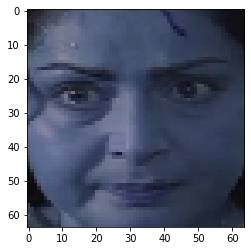

In [ ]:
plt.imshow(x[1])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=54)
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (15924, 64, 64, 3)
x_test shape:  (3982, 64, 64, 3)
y_train shape:  (15924,)
y_test shape:  (3982,)


In [ ]:
y_train.astype('float32')
y_test.astype('float32')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [ ]:
print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (15924, 64, 64, 3)
x_test shape:  (3982, 64, 64, 3)
y_train shape:  (15924, 3)
y_test shape:  (3982, 3)


# Age classification without transfer learning

# Model 1

In [ ]:
model = Sequential()

img_rows, img_cols = 64, 64

input_shape = (img_rows, img_cols, 3)

model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same',
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

In [ ]:
# Print model summary

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 activation_11 (Activation)  (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=30, epochs=50, verbose=2,
          validation_data=(x_test, y_test))

Epoch 1/50
531/531 - 10s - loss: 0.8882 - accuracy: 0.5946 - val_loss: 0.7838 - val_accuracy: 0.6590 - 10s/epoch - 19ms/step
Epoch 2/50
531/531 - 9s - loss: 0.7782 - accuracy: 0.6553 - val_loss: 0.7404 - val_accuracy: 0.6670 - 9s/epoch - 17ms/step
Epoch 3/50
531/531 - 8s - loss: 0.7334 - accuracy: 0.6743 - val_loss: 0.7367 - val_accuracy: 0.6843 - 8s/epoch - 16ms/step
Epoch 4/50
531/531 - 9s - loss: 0.6904 - accuracy: 0.7003 - val_loss: 0.7041 - val_accuracy: 0.6964 - 9s/epoch - 17ms/step
Epoch 5/50
531/531 - 8s - loss: 0.6491 - accuracy: 0.7224 - val_loss: 0.6927 - val_accuracy: 0.7039 - 8s/epoch - 16ms/step
Epoch 6/50
531/531 - 9s - loss: 0.6059 - accuracy: 0.7399 - val_loss: 0.6077 - val_accuracy: 0.7388 - 9s/epoch - 17ms/step
Epoch 7/50
531/531 - 9s - loss: 0.5602 - accuracy: 0.7611 - val_loss: 0.6043 - val_accuracy: 0.7509 - 9s/epoch - 17ms/step
Epoch 8/50
531/531 - 9s - loss: 0.5247 - accuracy: 0.7819 - val_loss: 0.5964 - val_accuracy: 0.7526 - 9s/epoch - 16ms/step
Epoch 9/50
531

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))
#precision score
prec_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(prec_score))
#F1 score
f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))
#prints classification report
print(metrics.classification_report(y_true, pred))


Recall score: 0.7933199397287795
Precision score: 0.7905175725547939
F1 score: 0.7895043764119178
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1332
           1       0.80      0.87      0.83      2165
           2       0.70      0.53      0.60       485

    accuracy                           0.79      3982
   macro avg       0.77      0.72      0.74      3982
weighted avg       0.79      0.79      0.79      3982



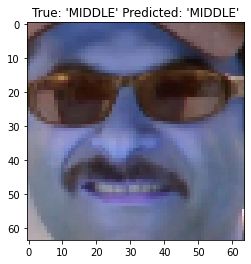

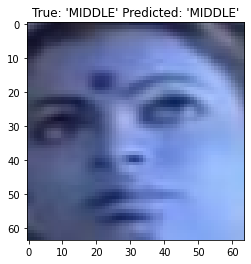

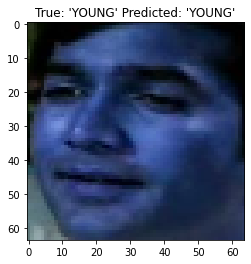

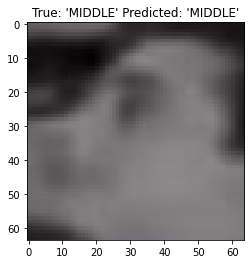

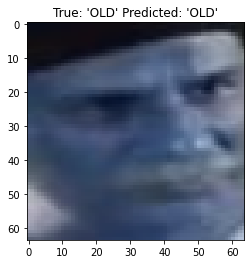

In [ ]:
label_names = ['YOUNG', 'MIDDLE', 'OLD']
for i in range(15, 20):
  image = x_test[i]
  y_label_index = np.where(y_test[i] == 1)
  plt.figure()
  plt.imshow(image)
  plt.title("True: '{}' Predicted: '{}'".format(label_names[y_label_index[0][0]], label_names[pred[i]]))

# Model 2

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

img_rows, img_cols = 64, 64

input_shape = (img_rows, img_cols, 3)

for i in range(3):
    print(i)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same',
                 activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))

    model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=2, mode='auto')

    model.fit(x_train, y_train, batch_size=30, epochs=50, verbose=2,
            validation_data=(x_test, y_test), callbacks=[checkpointer, monitor])

model.load_weights('best_weights.hdf5')

0
Epoch 1/50
531/531 - 12s - loss: 0.8989 - accuracy: 0.5877 - val_loss: 0.8485 - val_accuracy: 0.6416 - 12s/epoch - 23ms/step
Epoch 2/50
531/531 - 10s - loss: 0.7861 - accuracy: 0.6486 - val_loss: 0.7704 - val_accuracy: 0.6705 - 10s/epoch - 19ms/step
Epoch 3/50
531/531 - 9s - loss: 0.7414 - accuracy: 0.6701 - val_loss: 0.7535 - val_accuracy: 0.6803 - 9s/epoch - 18ms/step
Epoch 4/50
531/531 - 9s - loss: 0.7032 - accuracy: 0.6940 - val_loss: 0.7185 - val_accuracy: 0.6896 - 9s/epoch - 18ms/step
Epoch 5/50
531/531 - 9s - loss: 0.6648 - accuracy: 0.7112 - val_loss: 0.6987 - val_accuracy: 0.6976 - 9s/epoch - 17ms/step
Epoch 6/50
531/531 - 9s - loss: 0.6255 - accuracy: 0.7305 - val_loss: 0.6398 - val_accuracy: 0.7328 - 9s/epoch - 17ms/step
Epoch 7/50
531/531 - 9s - loss: 0.5874 - accuracy: 0.7524 - val_loss: 0.6275 - val_accuracy: 0.7398 - 9s/epoch - 17ms/step
Epoch 8/50
531/531 - 9s - loss: 0.5452 - accuracy: 0.7702 - val_loss: 0.5790 - val_accuracy: 0.7662 - 9s/epoch - 16ms/step
Epoch 9/50

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))
#precision score
prec_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(prec_score))
#F1 score
f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))
#prints classification report
print(metrics.classification_report(y_true, pred))

Recall score: 0.7719738824711201
Precision score: 0.7684968046956949
F1 score: 0.7658545591638664
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1332
           1       0.78      0.85      0.82      2165
           2       0.70      0.45      0.55       485

    accuracy                           0.77      3982
   macro avg       0.75      0.69      0.71      3982
weighted avg       0.77      0.77      0.77      3982



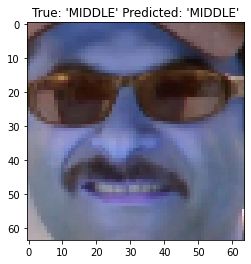

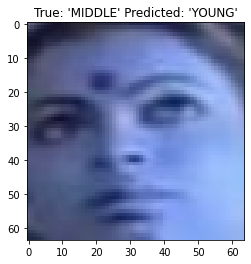

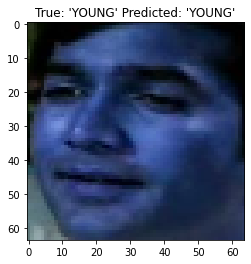

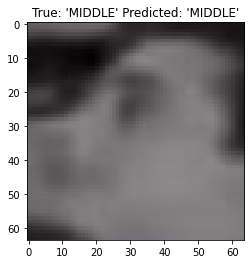

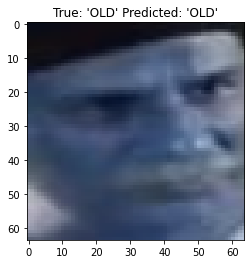

In [ ]:
label_names = ['YOUNG', 'MIDDLE', 'OLD']
for i in range(15, 20):
  image = x_test[i]
  y_label_index = np.where(y_test[i] == 1)
  plt.figure()
  plt.imshow(image)
  plt.title("True: '{}' Predicted: '{}'".format(label_names[y_label_index[0][0]], label_names[pred[i]]))

# Model 3

In [ ]:
model = Sequential()

img_rows, img_cols = 64, 64

input_shape = (img_rows, img_cols, 3)

model.add(Conv2D(64, kernel_size=(5,5), strides=(1,1), padding='same',
                 activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        4864      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 65536)             0         
                                                                 
 dense_10 (Dense)            (None, 500)               32768500  
                                                                 
 activation_10 (Activation)  (None, 500)               0         
                                                      

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=2, mode='auto')

model.fit(x_train, y_train, batch_size=30, epochs=50, verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

Epoch 1/50
531/531 - 16s - loss: 0.9051 - accuracy: 0.5964 - val_loss: 0.7982 - val_accuracy: 0.6409 - 16s/epoch - 31ms/step
Epoch 2/50
531/531 - 15s - loss: 0.7678 - accuracy: 0.6625 - val_loss: 0.7282 - val_accuracy: 0.6806 - 15s/epoch - 29ms/step
Epoch 3/50
531/531 - 15s - loss: 0.7118 - accuracy: 0.6888 - val_loss: 0.7005 - val_accuracy: 0.6954 - 15s/epoch - 28ms/step
Epoch 4/50
531/531 - 15s - loss: 0.6571 - accuracy: 0.7191 - val_loss: 0.6687 - val_accuracy: 0.7155 - 15s/epoch - 28ms/step
Epoch 5/50
531/531 - 15s - loss: 0.6027 - accuracy: 0.7455 - val_loss: 0.6546 - val_accuracy: 0.7200 - 15s/epoch - 28ms/step
Epoch 6/50
531/531 - 15s - loss: 0.5342 - accuracy: 0.7768 - val_loss: 0.7189 - val_accuracy: 0.7175 - 15s/epoch - 28ms/step
Epoch 7/50
531/531 - 15s - loss: 0.4758 - accuracy: 0.8036 - val_loss: 0.6722 - val_accuracy: 0.7325 - 15s/epoch - 28ms/step
Epoch 8/50
531/531 - 15s - loss: 0.4234 - accuracy: 0.8323 - val_loss: 0.7034 - val_accuracy: 0.7270 - 15s/epoch - 28ms/step


In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))
#precision score
prec_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(prec_score))
#F1 score
f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))
#prints classification report
print(metrics.classification_report(y_true, pred))

Recall score: 0.7491210447011551
Precision score: 0.7438391687906555
F1 score: 0.7402719367179681
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1332
           1       0.77      0.84      0.80      2165
           2       0.67      0.36      0.47       485

    accuracy                           0.75      3982
   macro avg       0.72      0.65      0.67      3982
weighted avg       0.74      0.75      0.74      3982



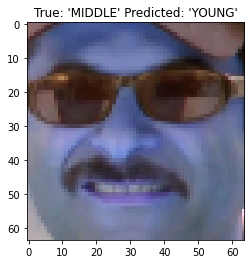

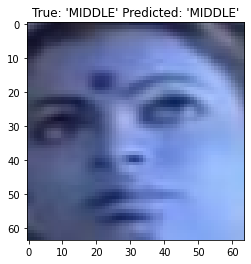

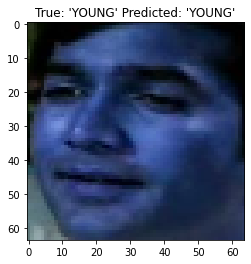

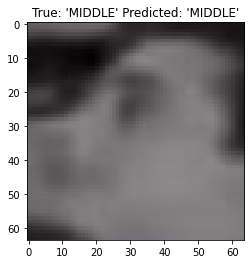

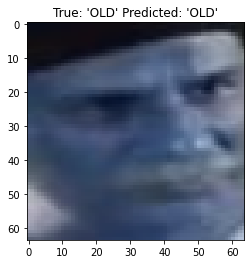

In [ ]:
label_names = ['YOUNG', 'MIDDLE', 'OLD']
for i in range(15, 20):
  image = x_test[i]
  y_label_index = np.where(y_test[i] == 1)
  plt.figure()
  plt.imshow(image)
  plt.title("True: '{}' Predicted: '{}'".format(label_names[y_label_index[0][0]], label_names[pred[i]]))

#Age Classification Using Transfer Learning

# Transfer Learning Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))   #  first hidden layer


model = Sequential()

  
# write your code here

#add remaining layers to model
for layer in vgg_model.layers:
  model.add(layer)

#fix weights from the pre-trained model by setting trainable to false for all layers
for layer in model.layers:
    layer.trainable = False;

#add other layers on top of the pre-trained model (dense layer) with softmax as activation layer
model.add(Dense(10, activation = 'softmax'))


# print out the model summary
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                       

In [ ]:
model.add(Flatten())

model.add(Dense(128, activation='relu'))

# Add some "Dense" layers here, including output layer

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=Adam(learning_rate=0.001, decay=1e-6), metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=2, mode='auto')

model.fit(x_train, y_train, batch_size=30, epochs=50, verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

Epoch 1/50
531/531 - 27s - loss: 0.8357 - accuracy: 0.6212 - val_loss: 0.8037 - val_accuracy: 0.6306 - 27s/epoch - 52ms/step
Epoch 2/50
531/531 - 23s - loss: 0.7771 - accuracy: 0.6506 - val_loss: 0.7777 - val_accuracy: 0.6509 - 23s/epoch - 44ms/step
Epoch 3/50
531/531 - 23s - loss: 0.7448 - accuracy: 0.6704 - val_loss: 0.7421 - val_accuracy: 0.6750 - 23s/epoch - 44ms/step
Epoch 4/50
531/531 - 23s - loss: 0.7220 - accuracy: 0.6836 - val_loss: 0.7240 - val_accuracy: 0.6808 - 23s/epoch - 44ms/step
Epoch 5/50
531/531 - 23s - loss: 0.7002 - accuracy: 0.6938 - val_loss: 0.7222 - val_accuracy: 0.6808 - 23s/epoch - 44ms/step
Epoch 6/50
531/531 - 24s - loss: 0.6877 - accuracy: 0.7030 - val_loss: 0.7142 - val_accuracy: 0.6906 - 24s/epoch - 45ms/step
Epoch 7/50
531/531 - 23s - loss: 0.6781 - accuracy: 0.7086 - val_loss: 0.7029 - val_accuracy: 0.6853 - 23s/epoch - 44ms/step
Epoch 8/50
531/531 - 23s - loss: 0.6666 - accuracy: 0.7129 - val_loss: 0.7049 - val_accuracy: 0.6941 - 23s/epoch - 44ms/step


In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true= np.argmax(y_test,axis=1) 

#recall score
recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))
#precision score
prec_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(prec_score))
#F1 score
f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))
#prints classification report
print(metrics.classification_report(y_true, pred))

Recall score: 0.6936212958312405
Precision score: 0.6883955906941875
F1 score: 0.6765472133406132
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1332
           1       0.72      0.79      0.75      2165
           2       0.64      0.21      0.31       485

    accuracy                           0.69      3982
   macro avg       0.67      0.57      0.58      3982
weighted avg       0.69      0.69      0.68      3982



In [ ]:
jose = cv2.imread('/content/jose.jpg')
jose = cv2.resize(jose, (64, 64))
ethan = cv2.imread('/content/ethan.jpg')
ethan = cv2.resize(ethan, (64, 64))
us = []
us.append(jose)
us.append(ethan)
us = np.array(us)
print(us.shape)
us = us.astype('float32')
us /= 255

(2, 64, 64, 3)


[0 1]


Text(0.5, 1.0, "True: 'YOUNG' Predicted: 'MIDDLE'")

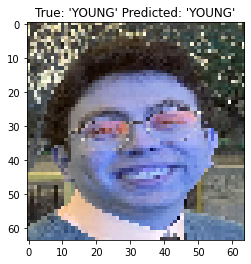

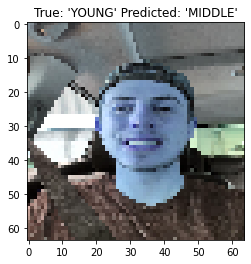

In [ ]:
label_names = ['YOUNG', 'MIDDLE', 'OLD']
pred_test = model.predict(us)
pred_test = np.argmax(pred_test,axis=1)
print(pred_test)
plt.figure()
plt.imshow(jose)
plt.title("True: 'YOUNG' Predicted: '{}'".format(label_names[pred_test[0]]))
plt.figure()
plt.imshow(ethan)
plt.title("True: 'YOUNG' Predicted: '{}'".format(label_names[pred_test[1]]))

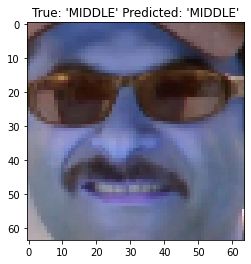

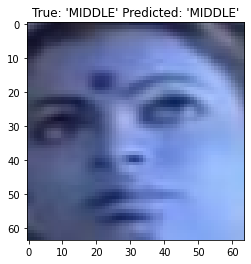

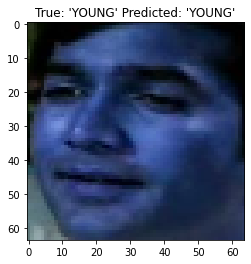

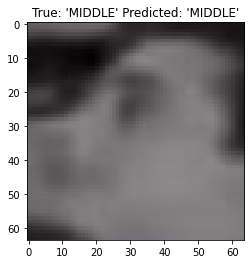

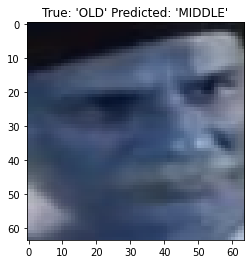

In [ ]:
label_names = ['YOUNG', 'MIDDLE', 'OLD']
for i in range(15, 20):
  image = x_test[i]
  y_label_index = np.where(y_test[i] == 1)
  plt.figure()
  plt.imshow(image)
  plt.title("True: '{}' Predicted: '{}'".format(label_names[y_label_index[0][0]], label_names[pred[i]]))